In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.linear_model import (HuberRegressor, TheilSenRegressor, 
                                  LinearRegression as SkLinearRegression)
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import normalize
from abess.linear import LinearRegression
from bess import PdasLm
from utils import BIC_AIC

import numpy as np; np.random.seed(0)

# from pde_diff import *
from pde_diff_new import * # moving to the newer version of PDE-FIND

from parametric_pde_find import *
# from robust_pde_diff import DLrSR, RobustPCA
# https://github.com/nerdull/denoise
# from denoise import Denoiser, kalman_denoise
from tvregdiff import TVRegDiff, tvregdiff, numdiff, pysindydiff
import pynumdiff
import sys; sys.path.insert(0, "../derivative/"); import derivative

from RobustPCA.rpca import RobustPCA
from RobustPCA.spcp import StablePCP
# from hyperspy.signals import Signal1D
from r_pca import R_pca

from scipy.integrate import odeint
from scipy.linalg import block_diag
from scipy.special import huber as hb
from scipy.signal import wiener, savgol_filter # (+0, +1)
from numpy.fft import fft, ifft, fftfreq
from best_subset import *
import statsmodels.api as sm
# from pysr import PySRRegressor

import random; SEEED = 0; random.seed(SEEED)
from random import randint, sample
from tqdm import trange, tqdm
from time import time
from functools import cmp_to_key

Running Python 3.7.12
You can use npar for np.array


In [2]:
def parametric_burgers_rhs(u, t, params):
    k,a,b,c = params
    deriv = a*(1+c*np.sin(t))*u*ifft(1j*k*fft(u)) + b*ifft(-k**2*fft(u))
    return deriv.real

In [3]:
def parametric_burgers_rhs(u, t, params):
    k,a,b,c = params
    deriv = a*(1+c*np.sin(t))*u*ifft(1j*k*fft(u)) + b*ifft(-k**2*fft(u))
    return deriv.real

In [4]:
# Set size of grid
n = 256
m = 256

# Set up grid
x = np.linspace(-8,8,n+1)[:-1];   dx = x[1]-x[0]
t = np.linspace(0,10,m);          dt = t[1]-t[0]
k = 2*np.pi*fftfreq(n, d = dx)

# Initial condition
u0 = np.exp(-(x+1)**2)

# Solve with time dependent uu_x term
params = (k, -1, 0.1, 0.25)
u = odeint(parametric_burgers_rhs, u0, t, args=(params,)).T

u_xx_true = 0.1*np.ones(m)
uu_x_true = -1*(1+0.25*np.sin(t))

In [5]:
# # Plot
# fig=figure(figsize=(16,4))
# X, T = np.meshgrid(x, t)

# subplot(1,2,1)
# pcolor(X, T, u.T, cmap=cm.coolwarm)
# xlabel('x', fontsize = fontsize)
# ylabel('t', fontsize = fontsize)
# xticks(fontsize = fontsize)
# yticks(fontsize = fontsize)
# xlim([x[0],x[-1]])

# subplot(1,2,2)
# plot(t, uu_x_true, label=r'$uu_{x}$')
# plot(t, u_xx_true, label=r'$u_{xx}$')

# xticks(fontsize = fontsize)
# yticks(fontsize = fontsize)
# xlabel('t', fontsize = fontsize)
# legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = fontsize+2)
# fig.tight_layout()

#### Computing dervatives + std Noise

In [6]:
# just for the reference
u_clean = u.copy()
Ut_clean, Theta_clean, rhs_des_clean = build_linear_system(u_clean, dt, dx, D=4, P=3, time_diff = 'FD', space_diff = 'FD')
# np.allclose(Theta_clean[:, 1:2], u_clean.T.flatten().reshape(-1, 1)) == True
Theta_grouped_clean = [(Theta_clean[j*n:(j+1)*n,:]).real for j in range(m)]
Ut_grouped_clean = [(Ut_clean[j*n:(j+1)*n]).real for j in range(m)]
# finitediff_x = Theta_grouped[1][:, 3:4].flatten()

noise_lv = 90; noise = 0.01*np.abs(noise_lv)*u.std()*np.random.randn(n,m)
u = u + noise

if np.abs(noise_lv) > 0:
    # Build linear systems
    # D=3 and p=2 for the noise-aware physics-informed paper
    wx = 10; wt = 10
    Ut, Theta, rhs_des = build_linear_system(u, dt, dx, D=4, P=3, time_diff = 'poly',
                                           deg_x = 6, deg_t = 4, 
                                           width_x = wx, width_t = wt)
    n = n - 2*wx
    m = m - 2*wt
else:
    wx = 0; wt = 0
    Ut, Theta, rhs_des = build_linear_system(u, dt, dx, D=4, P=3, time_diff = 'FD', space_diff = 'FD')

# removing the constant term...
Theta = Theta[:, 1:]; rhs_des = rhs_des[1:]
# Group by timestep
Theta_grouped = [(Theta[j*n:(j+1)*n,:]).real for j in range(m)]
Ut_grouped = [(Ut[j*n:(j+1)*n]).real for j in range(m)]

In [7]:
# print(mse(u, u_clean))

# ### not really working ###
# # sig1d_u = Signal1D(u)
# # sig1d_u.decomposition(algorithm="ORPCA", output_dimension=3, lambda1=5e-2)
# # u = sig1d_u.get_decomposition_model().data

# # also works
# # u, _ = R_pca(u, lmbda=5e-2).fit(max_iter=5000, iter_print=1000)

rpca = RobustPCA(lamb=5e-2, tol=10, use_fbpca=True, max_iter=int(1e6)); rpca.fit(u)
u = rpca.get_low_rank()

# print(mse(u, u_clean))

Converged!


In [8]:
## using pysindydiff ###
# diff_func = derivative.SavitzkyGolay(left=.5, right=.5, order=3, periodic=False)
# diff_func = derivative.TrendFiltered(alpha=5e-2, order=0, max_iter=int(1e6))
diff_func = derivative.Kalman(alpha=0.25) # 0.25

n = n + 2*wx; wx = 10; n = n - 2*wx
m = m + 2*wt; wt = 10; m = m - 2*wt

if wx > 0 and wt > 0:
    x = x[wx:-wx]
    t = t[wt:-wt]
    u = u[wx:-wx, wt:-wt]

f = u.copy()
f_x = np.hstack([pysindydiff(u[:, j:j+1], x, diff_func, order=1).reshape(-1, 1) for j in range(u.shape[1])])
f_xx = np.hstack([pysindydiff(u[:, j:j+1], x, diff_func, order=2).reshape(-1, 1) for j in range(u.shape[1])])
f_xxx = np.hstack([pysindydiff(u[:, j:j+1], x, diff_func, order=3).reshape(-1, 1) for j in range(u.shape[1])])
f_xxxx = np.hstack([pysindydiff(u[:, j:j+1], x, diff_func, order=4).reshape(-1, 1) for j in range(u.shape[1])])
f_t = np.hstack([pysindydiff(u[j:j+1, :], t, diff_func, order=1).reshape(-1, 1) for j in range(u.shape[0])])

# if wx > 0 and wt > 0:
#     x = x[wx:-wx]
#     t = t[wt:-wt]
#     f = f[wx:-wx, wt:-wt]
#     f_x = f_x[wx:-wx, wt:-wt]
#     f_xx = f_xx[wx:-wx, wt:-wt]
#     f_xxx = f_xxx[wx:-wx, wt:-wt]
#     f_xxxx = f_xxxx[wx:-wx, wt:-wt]
#     f_t = f_t[wx:-wx, wt:-wt]

In [9]:
# ### using tvregdiff ###
# # alph = 0.05
# # f_x = np.hstack([tvregdiff(u[:, j:j+1], delta=dx, alph=alph, order=1).reshape(-1, 1) for j in range(u.shape[1])])
# # f_xx = np.hstack([tvregdiff(u[:, j:j+1], delta=dx, alph=alph, order=2).reshape(-1, 1) for j in range(u.shape[1])])
# # f_xxx = np.hstack([tvregdiff(u[:, j:j+1], delta=dx, alph=alph, order=3).reshape(-1, 1) for j in range(u.shape[1])])
# # f_xxxx = np.hstack([tvregdiff(u[:, j:j+1], delta=dx, alph=alph, order=4).reshape(-1, 1) for j in range(u.shape[1])])
# # f_t = np.hstack([tvregdiff(u[j:j+1, :], delta=dt, alph=alph, order=1).reshape(-1, 1) for j in range(u.shape[0])])

# ### using numdiff ###
# diff_func = pynumdiff.smooth_finite_difference.butterdiff
# params = [3, 0.099]; options={'iterate': False} # [3, 0.099]

# n = n + 2*wx; wx = 0; n = n - 2*wx
# m = m + 2*wt; wt = 0; m = m - 2*wt

# if wx > 0 and wt > 0:
#     x = x[wx:-wx]
#     t = t[wt:-wt]
#     u = u[wx:-wx, wt:-wt]

# f = u.copy()
# # f = np.hstack([numdiff(u[:, j:j+1], dx, diff_func, params, options, order=0).reshape(-1, 1) for j in range(u.shape[1])])
# f_x = np.hstack([numdiff(u[:, j:j+1], dx, diff_func, params, options, order=1).reshape(-1, 1) for j in range(u.shape[1])])
# f_xx = np.hstack([numdiff(u[:, j:j+1], dx, diff_func, params, options, order=2).reshape(-1, 1) for j in range(u.shape[1])])
# f_xxx = np.hstack([numdiff(u[:, j:j+1], dx, diff_func, params, options, order=3).reshape(-1, 1) for j in range(u.shape[1])])
# f_xxxx = np.hstack([numdiff(u[:, j:j+1], dx, diff_func, params, options, order=4).reshape(-1, 1) for j in range(u.shape[1])])
# f_t = np.hstack([numdiff(u[j:j+1, :], dt, diff_func, params, options, order=1).reshape(-1, 1) for j in range(u.shape[0])])

# # if wx > 0 and wt > 0:
# #     f = f[wx:-wx, wt:-wt]
# #     f_x = f_x[wx:-wx, wt:-wt]
# #     f_xx = f_xx[wx:-wx, wt:-wt]
# #     f_xxx = f_xxx[wx:-wx, wt:-wt]
# #     f_xxxx = f_xxxx[wx:-wx, wt:-wt]
# #     f_t = f_t[wx:-wx, wt:-wt]

In [10]:
# ### not really working ###
# # sig1d_ut = Signal1D(f_t)
# # sig1d_ut.decomposition(algorithm="ORPCA", output_dimension=3, lambda1=5e-2)
# # f_t = sig1d_ut.get_decomposition_model().data

# # also works
# # f_t, _ = R_pca(f_t, lmbda=5e-2).fit(max_iter=5000, iter_print=1000)

rpca_ut = RobustPCA(lamb=5e-2, tol=10, use_fbpca=True, max_iter=int(1e6)); rpca_ut.fit(f_t)
f_t = rpca_ut.get_low_rank()

# # print(mse(f_t, Ut_clean.reshape(256, 256)[wx:-wx, wt:-wt]))

Converged!


In [11]:
basis_candidates = [f, f_x, f_xx, f_xxx, f_xxxx]; candidate_lib = []

# for i in range(1, len(basis_candidates)):
#     rpca_transformer = RobustPCA(lamb=5e-2, tol=10, use_fbpca=True, max_iter=int(1e6))
#     rpca_transformer.fit(basis_candidates[i])
#     basis_candidates[i] = rpca_transformer.get_low_rank()
    
for e in rhs_des:
    out = 1
    for o, d in get_order_degree(e, accumulate=False):
        out = out*(basis_candidates[o]**d)
    out = out.T.flatten().reshape(-1, 1)
    candidate_lib.append(out)
candidate_lib = np.hstack(candidate_lib)
dynamics = f_t.flatten().reshape(-1, 1)

# Theta = candidate_lib
# Ut = dynamics
Theta_grouped = [candidate_lib[j*n:(j+1)*n,:] for j in range(m)]
Ut_grouped = [dynamics[j*n:(j+1)*n] for j in range(m)]
# also ok...
# Theta = np.vstack(Theta_grouped)
# Ut = np.vstack(Ut_grouped)
# this is very important!!!
Theta = candidate_lib.copy()
Ut = dynamics.copy()

del candidate_lib, dynamics, basis_candidates
# mean_squared_error(Theta, Theta_clean[:,1:])

In [12]:
# dv = 6; pd = 2
# f_x = np.hstack([tvregdiff(u[:, j:j+1], delta=dx, order=1, divide = dv, poly_degree = pd).reshape(-1, 1) for j in range(u.shape[1])])
# f_xx = np.hstack([tvregdiff(u[:, j:j+1], delta=dx, order=2, divide = dv, poly_degree = pd).reshape(-1, 1) for j in range(u.shape[1])])
# f_xxx = np.hstack([tvregdiff(u[:, j:j+1], delta=dx, order=3, divide = dv, poly_degree = pd).reshape(-1, 1) for j in range(u.shape[1])])
# f_xxxx = np.hstack([tvregdiff(u[:, j:j+1], delta=dx, order=4, divide = dv, poly_degree = pd).reshape(-1, 1) for j in range(u.shape[1])])
# f_t = np.hstack([tvregdiff(u[j:j+1, :], delta=dt, order=1, divide = dv, poly_degree = pd).reshape(-1, 1) for j in range(u.shape[0])])

# basis_candidates = [u, f_x, f_xx, f_xxx, f_xxxx]; candidate_lib = []
# for e in rhs_des:
#     out = 1
#     for o, d in get_order_degree(e, accumulate=False):
#         out = out*(basis_candidates[o]**d)
#     out = out.T.flatten().reshape(-1, 1)
#     candidate_lib.append(out)
# candidate_lib = np.hstack(candidate_lib)
# dynamics = f_t.flatten().reshape(-1, 1)

# Theta_grouped = [(candidate_lib[j*n:(j+1)*n,:]).real for j in range(m)]
# Ut_grouped = [(dynamics[j*n:(j+1)*n]).real for j in range(m)]
# del candidate_lib, dynamics, basis_candidates

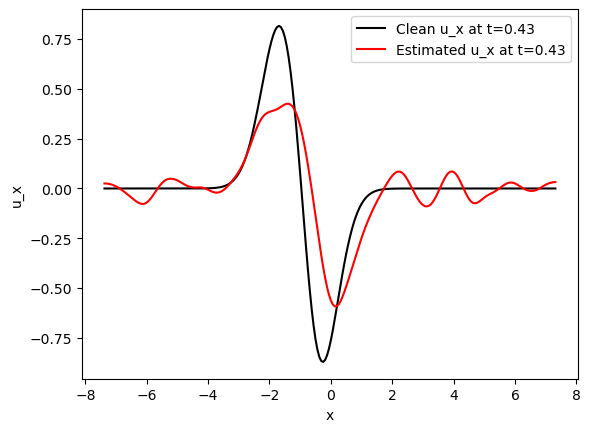

0.02684986639476082

In [13]:
time_step = 1
ground = Theta_grouped_clean[time_step][:, 4:5].flatten()
if wx > 0 and wt > 0: ground = ground[wx:-wx]
plt.plot(x, ground, label=f'Clean u_x at t={format(t[1], ".2f")}', color='black')
plt.plot(x, f_x[:, time_step:time_step+1], label=f'Estimated u_x at t={format(t[1], ".2f")}', color='red')
plt.xlabel('x')
plt.ylabel('u_x')
plt.legend()
# plt.savefig("./imgs/noisy_diff_90%noise.pdf")
plt.show()
mse(f_x[:, time_step:time_step+1], ground)

#### Denoised derivatives

In [14]:
#### savgol_filter (45, 2) -> now best param | (41, 2) -> now second-best param #####
# also try window_length = 3; poly_deg = 2 and window_length = 45; poly_deg = 2
savgol_end = True
if savgol_end:
    divide = 6
    # window_length = 41
    poly_deg = 2
    for i in trange(len(Theta_grouped)):
        window_length = Ut_grouped[i].shape[0]//divide
        if window_length%2 == 0: window_length -= 1
        Ut_grouped[i] = savgol_filter(Ut_grouped[i].flatten(), window_length, poly_deg).reshape(-1, 1)
        for j in range(Theta_grouped[i].shape[1]):
            window_length = Theta_grouped[i].shape[0]//divide
            if window_length%2 == 0: window_length -= 1
            Theta_grouped[i][:, j:j+1] = savgol_filter(Theta_grouped[i][:, j:j+1].flatten(), window_length, poly_deg).reshape(-1, 1)
# Change/Unchange Theta and Ut (test data)
# Theta = np.vstack(Theta_grouped)
# Ut = np.vstack(Ut_grouped)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 236/236 [00:01<00:00, 150.86it/s]


In [15]:
Xi,Tol,Losses = TrainSGTRidge(Theta_grouped, Ut_grouped)
xi = Xi[np.argmin(Losses)]

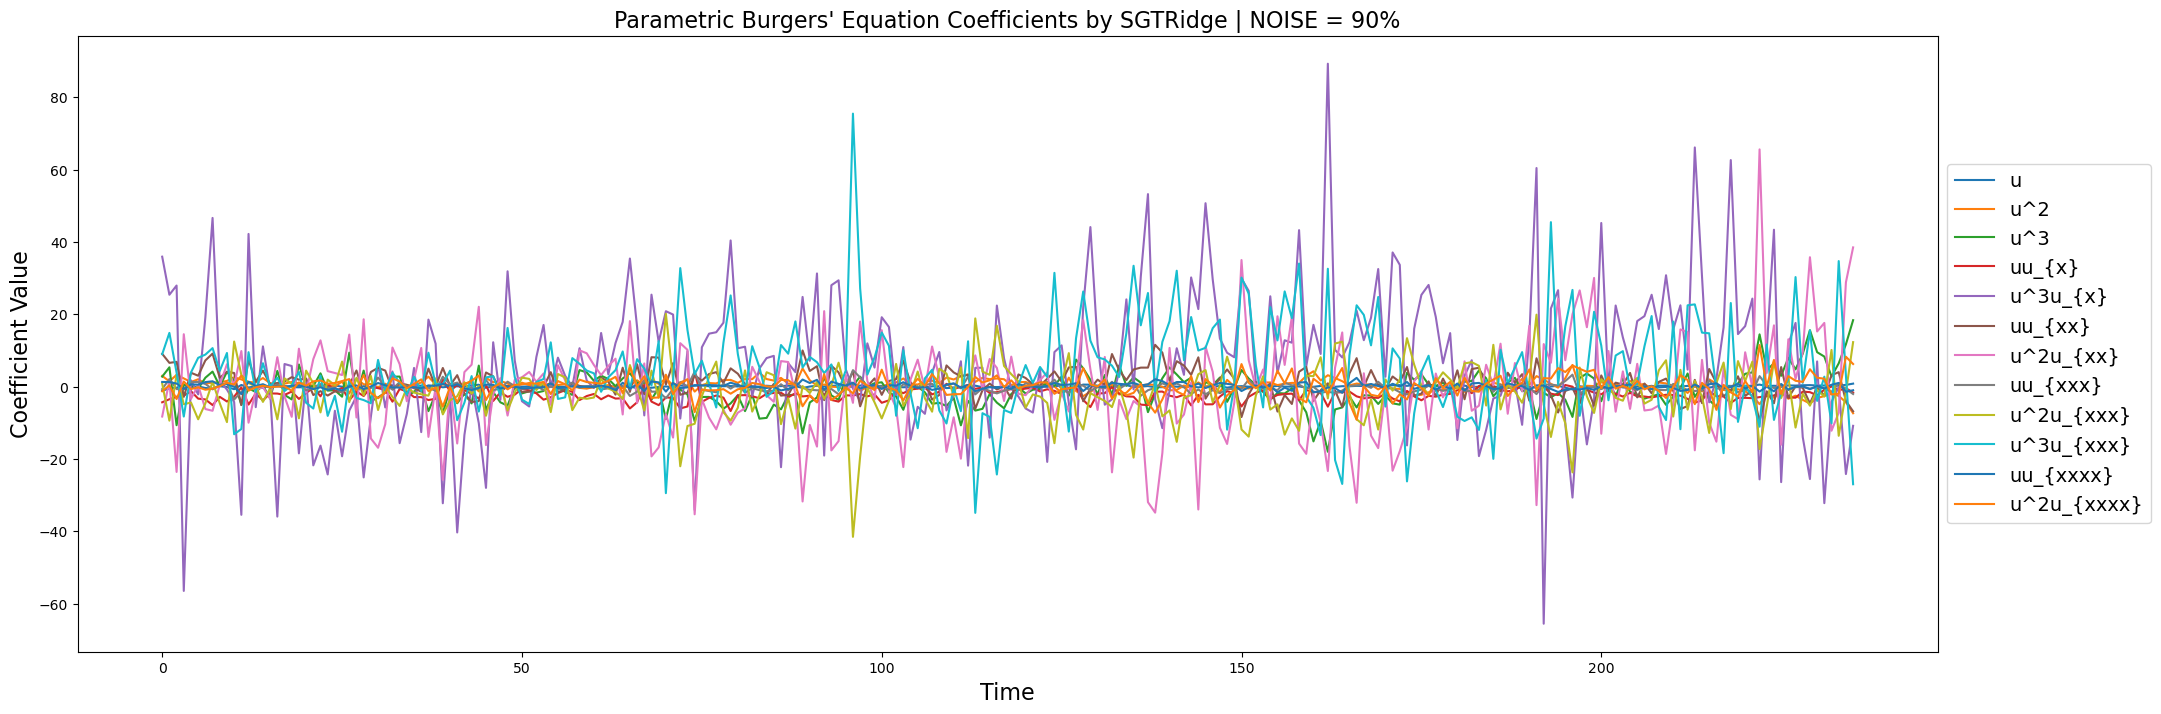

0.0019836449627494545


(203.0664684120126, 100.13415888078647)

In [16]:
stgridge_indices = []
fig = plt.figure(figsize=(24, 8))
for j in range(xi.shape[0]): 
    if np.linalg.norm(xi[j,:]) > 10**-10:
        stgridge_indices.append(j)
        plt.plot(xi[j,:], label = rhs_des[j])
stgridge_indices = np.array(stgridge_indices)
plt.title(f"Parametric Burgers' Equation Coefficients by SGTRidge | NOISE = {int(noise_lv)}%", fontsize = 16)
plt.xlabel('Time', fontsize = 16)
plt.ylabel('Coefficient Value', fontsize = 16)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)
# plt.savefig("./imgs/sgtridge_90%noise.pdf")
plt.show()

consider = Theta[:, stgridge_indices]
xi = xi[stgridge_indices, :]
pred = np.array([consider[:, i:i+1]*xi[i].repeat(n).reshape(-1, 1) for i in range(len(xi))]).sum(axis=0)
print(mse(pred, Ut))

ground = -0.25*np.sin(t)-1
if wx > 0 and wt > 0:
    errs = np.array([100*np.linalg.norm(xi[0, :]-ground, 1)/np.linalg.norm(ground, 1), 
                     100*(np.abs(xi[1, :].mean()-0.1))/0.1])
else:
    errs = np.array([100*np.linalg.norm(xi[0, :]-ground, 1)/np.linalg.norm(ground, 1), 
                     100*(np.abs(xi[1, :].mean()-0.1))/0.1])
errs.mean(), errs.std()

#### l0bnb

In [17]:
maximal_complexity = min(len(stgridge_indices)+1, 10)
bnb_candidates = set()
for i in trange(m):
    bnb_sols = bnb(Theta_grouped[i], Ut_grouped[i], maximal_complexity, corrected_coefficients=False)
    for j in range(bnb_sols.shape[1]):
        indices = tuple(np.nonzero(bnb_sols[:, j:j+1])[0])
        if indices not in bnb_candidates:
            bnb_candidates.add(indices)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 236/236 [03:33<00:00,  1.10it/s]


In [18]:
bnb_aic_scores = {}
for indices in bnb_candidates:
    ws = []; perf = []
    for j in range(m):
        bnb_wei = np.linalg.lstsq(Theta_grouped[j][:, indices], Ut_grouped[j], rcond=None)[0]
        perf.append(mse(Theta_grouped[j][:, indices]@bnb_wei, Ut_grouped[j]))
        ws.append(bnb_wei)
        
    perf = np.array(perf).mean()
    xi = np.hstack(ws)
    
    consider = Theta[:, indices]
    pred = np.array([consider[:, i:i+1]*xi[i].repeat(n).reshape(-1, 1) for i in range(len(xi))]).sum(axis=0)
    com = np.vstack([get_order_degree(rhs_des[ind]) for ind in indices]).sum()
    aic = BIC_AIC(pred, Ut, com)[1]
    
    if len(indices) not in bnb_aic_scores: bnb_aic_scores[len(indices)] = (aic, indices)
    elif aic < bnb_aic_scores[len(indices)][0]: bnb_aic_scores[len(indices)] = (aic, indices)
    
bnb_aic_scores

{7: (-218441.1452350797, (1, 3, 4, 5, 7, 11, 15)),
 4: (-216552.12648601364, (1, 3, 4, 7)),
 6: (-217973.76068660908, (1, 3, 4, 7, 11, 15)),
 5: (-217559.9125657268, (1, 3, 4, 7, 12)),
 10: (-215714.4002840598, (0, 1, 3, 4, 7, 11, 12, 14, 15, 16)),
 8: (-218384.0688395265, (0, 3, 4, 7, 11, 13, 15, 16)),
 3: (-213336.61913443764, (3, 4, 7)),
 2: (-209111.13360382244, (4, 7)),
 9: (-216637.49452057178, (0, 3, 4, 5, 7, 8, 11, 14, 15)),
 1: (-201693.79039871707, (3,))}

#### Single group

In [19]:
complexity_limit = 5
nor = 'l2'
aic_scores = {}
for com in range(1, min(len(stgridge_indices), complexity_limit)+1):
    track = set(); min_perf = 1000; best_indices = (); best_ws = []
    for i in range(m):
        abess_model = PdasLm(path_type="seq", sequence=[com], is_cv=True, K=5); coeff_attr = "beta"
        # abess_model = LinearRegression(max_iter=100, exchange_num=10, support_size=com, path_type="seq", cv=5); coeff_attr = "coef_"
        if nor is not None: abess_model.fit(Theta_grouped[i], Ut_grouped[i].ravel(), is_normal=False)
        else: abess_model.fit(normalize(Theta_grouped[i], nor, axis=0), Ut_grouped[i].ravel(), is_normal=False)
        indices = tuple(np.where(np.abs(getattr(abess_model, coeff_attr)) > 0)[0])
        if indices not in track:
            track.add(indices)
            ws = []; perf = []
            for j in range(m):
                w = np.linalg.lstsq(Theta_grouped[j][:, indices], Ut_grouped[j], rcond=None)[0]
                perf.append(mse(Theta_grouped[j][:, indices]@w, Ut_grouped[j]))
                ws.append(w)
            perf = np.array(perf).mean()
            # print(indices, perf)
            if perf < min_perf:
                min_perf = perf
                best_indices = indices
                best_ws = ws
    xi = np.hstack(best_ws)
    
    # track info criterion on undenoised Theta
    consider = Theta[:, best_indices]
    pred = np.array([consider[:, i:i+1]*xi[i].repeat(n).reshape(-1, 1) for i in range(len(xi))]).sum(axis=0)
    # comp = com
    comp = np.vstack([get_order_degree(rhs_des[ind]) for ind in best_indices]).sum()
    info_criterion = BIC_AIC(pred, Ut, comp)[1]
    aic_scores[best_indices] = info_criterion
    print(best_indices, info_criterion)
    
    SGT_Xi, _, SGT_Losses = TrainSGTRidge([g[:, best_indices] for g in Theta_grouped], Ut_grouped)
    SGT_Xi = SGT_Xi[np.argmin(SGT_Losses)]
    SGT_indices = [i for i in range(SGT_Xi.shape[0]) if np.linalg.norm(SGT_Xi[i,:]) > 1e-10]
    SGT_Xi = SGT_Xi[SGT_indices, :]
    SGT_indices = tuple([best_indices[i] for i in SGT_indices])
    if SGT_indices != best_indices:
        print("Dimensionality reduction by SGTRidge")
        pred = np.array([consider[:, i:i+1]*SGT_Xi[i].repeat(n).reshape(-1, 1) for i in range(len(SGT_Xi))]).sum(axis=0)
        comp = len(SGT_indices)
        comp = np.vstack([get_order_degree(rhs_des[ind]) for ind in SGT_indices]).sum()
        info_criterion = BIC_AIC(pred, Ut, comp)[1]
        if len(SGT_indices) not in set(len(e) for e in aic_scores.keys()):
            aic_scores[SGT_indices] = info_criterion
        else: 
            ref_indices = next(filter(lambda e: (len(e) == len(SGT_indices)), list(aic_scores.keys())))
            if info_criterion < aic_scores[ref_indices]:
                print(SGT_indices, "improves the AIC score")
                aic_scores[SGT_indices] = info_criterion
                aic_scores.pop(ref_indices)

(3,) -201693.79039871707
(4, 7) -209111.13360382244
(1, 4, 7) -212213.01913030667
(1, 4, 5, 7) -216394.0053424246
(1, 2, 5, 6, 7) -205418.6884516203


#### Grouped ABESS

In [20]:
support_sizes = [i+1 for i in range(complexity_limit)]; chooses = [2, 3, 4]
max_iters = 3000; nor = 'l2'
track = set()
# aic_scores = {}
for choose in chooses:
    print("choose =", choose)
    n_basis_candidates = Theta_grouped[0].shape[1]
    groups = np.linspace(0, n_basis_candidates-1, n_basis_candidates)
    n_groups = choose
    group_index = groups.repeat(n_groups)
    combinations = list(itertools.combinations(range(len(Theta_grouped)), choose))
    combi_samples = sample(combinations, max_iters)

    for support_size in support_sizes:
        print("support_size =", support_size)
        lowest_ic = 1e6; good_indices = None
        for blocks in combi_samples: # tqdm ครอบได้
            # n_groups == len(blocks)
            F = block_diag(*[Theta_grouped[b] for b in blocks])
            T = np.vstack([Ut_grouped[b] for b in blocks])
            F = F[:, np.hstack([[i*n_basis_candidates+j for i in range(n_groups)] for j in range(n_basis_candidates)])]
            
            lr = PdasLm(path_type="seq", sequence=[support_size], is_cv=True, K=5); coeff_attr = "beta"
            # lr = LinearRegression(max_iter=100, exchange_num=10, support_size=support_size, path_type="seq", cv=5); coeff_attr = "coef_"
            if nor is not None: lr.fit(normalize(F, nor, axis=0), T.ravel(), group=group_index, is_normal=False)
            else: lr.fit(F, T.ravel(), group=group_index, is_normal=False)
            indices = tuple(set(np.nonzero(getattr(lr, coeff_attr))[0]//n_groups))
            # com = len(indices)
            com = np.vstack([get_order_degree(rhs_des[ind]) for ind in indices]).sum()

            if indices not in track:
                track.add(indices)
                # Theta_grouped[j][:, indices] ไม่ต้อง normalize เลย
                xi = np.hstack([np.linalg.lstsq(Theta_grouped[j][:, indices], Ut_grouped[j], rcond=None)[0] for j in range(m)])
                consider = Theta[:, indices]
                pred = np.array([consider[:, i:i+1]*xi[i].repeat(n).reshape(-1, 1) for i in range(len(xi))]).sum(axis=0)
                info_criterion = BIC_AIC(pred, Ut, com)[1]
                # print(indices, info_criterion)

                # Calculate the information criterion for all elements in Theta_grouped.
                if info_criterion < lowest_ic: 
                    lowest_ic = info_criterion
                    good_indices = indices
        
        if good_indices is not None:
            # if len(aic_scores) == 0: aic_scores[good_indices] = lowest_ic
            if len(aic_scores) >= support_size-1:
                ref_indices = next(filter(lambda e: (len(e) == len(good_indices)), list(aic_scores.keys())))
                if lowest_ic < aic_scores[ref_indices]:
                    aic_scores[good_indices] = lowest_ic
                    aic_scores.pop(ref_indices)
            else: aic_scores[good_indices] = lowest_ic
            
    print(aic_scores); print('-'*80)

choose = 2
support_size = 1
support_size = 2
support_size = 3
support_size = 4
support_size = 5
{(3,): -201693.79039871707, (4, 7): -209111.13360382244, (3, 4, 7): -213336.61913443764, (1, 3, 4, 7): -216552.12648601364, (0, 3, 4, 7, 12): -217072.67172900203}
--------------------------------------------------------------------------------
choose = 3
support_size = 1
support_size = 2
support_size = 3
support_size = 4
support_size = 5
{(3,): -201693.79039871707, (4, 7): -209111.13360382244, (3, 4, 7): -213336.61913443764, (1, 3, 4, 7): -216552.12648601364, (0, 3, 4, 7, 12): -217072.67172900203}
--------------------------------------------------------------------------------
choose = 4
support_size = 1
support_size = 2
support_size = 3
support_size = 4
support_size = 5
{(3,): -201693.79039871707, (4, 7): -209111.13360382244, (3, 4, 7): -213336.61913443764, (1, 3, 4, 7): -216552.12648601364, (0, 3, 4, 7, 12): -217072.67172900203}
-------------------------------------------------------------

In [21]:
# Merge coef l0bnb aic_scores
sorted_cans = sorted(aic_scores.keys(), key=cmp_to_key(lambda ind1, ind2: len(ind1)-len(ind2)))
for i, support_size in enumerate(support_sizes):
    if bnb_aic_scores[support_size][0] < aic_scores[sorted_cans[i]]:
        aic_scores[bnb_aic_scores[support_size][1]] = bnb_aic_scores[support_size][0]
        aic_scores.pop(sorted_cans[i])

In [22]:
min_aic = 1e6
filtered_aic_scores = []; cans = []
sorted_cans = sorted(aic_scores.keys(), key=cmp_to_key(lambda ind1, ind2: len(ind1)-len(ind2)))
for can in sorted_cans:
    if len(can) > complexity_limit: break
    aic = aic_scores[can]
    if aic < min_aic:
        min_aic = aic
        filtered_aic_scores.append(aic)
        cans.append(can)
filtered_aic_scores = np.array(filtered_aic_scores)
filtered_aic_scores = filtered_aic_scores-np.min(filtered_aic_scores)

In [23]:
if len(filtered_aic_scores) > 1:
    support_size_diff = np.array([len(e) for e in cans])
    support_size_diff = support_size_diff[1:]-support_size_diff[:-1]
    bc = (np.argsort((filtered_aic_scores[1:]-filtered_aic_scores[:-1])/support_size_diff)+1)[0]
else: bc = 0
best_indices = cans[bc]
best_indices

(4, 7)

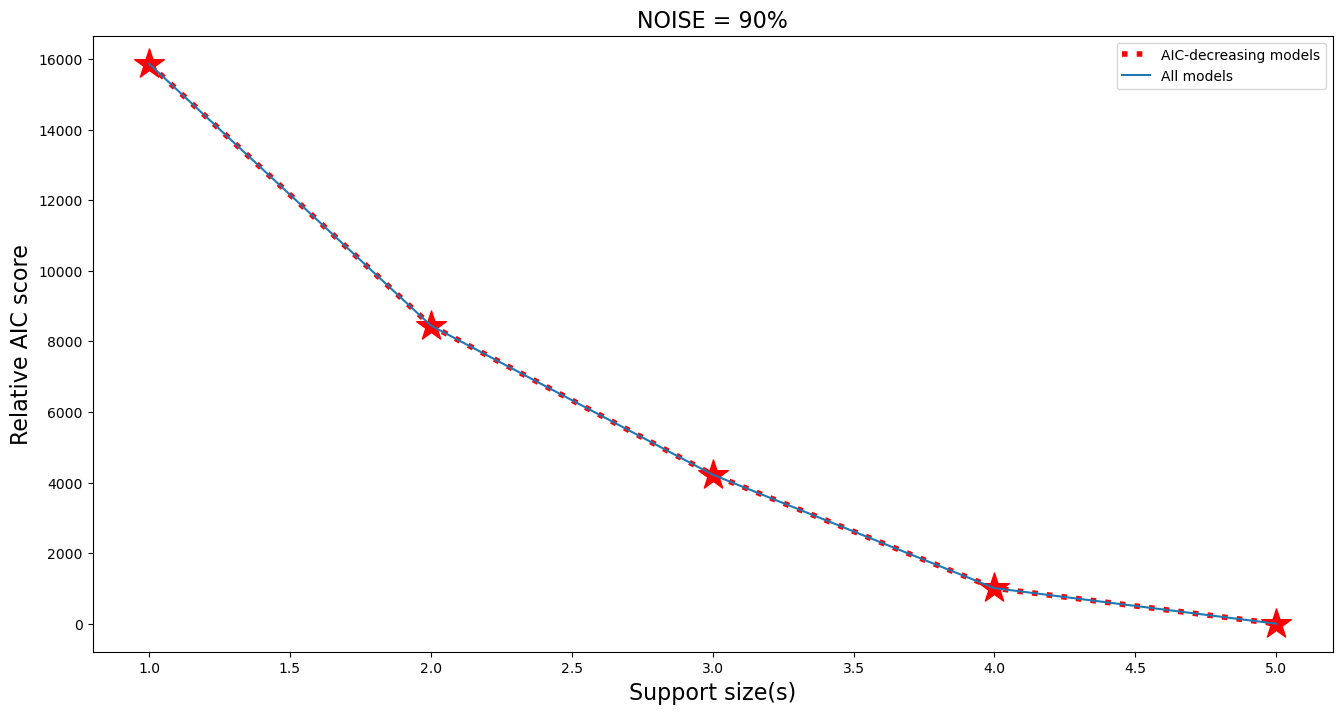

In [24]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot([len(e) for e in cans], filtered_aic_scores, ':', color='red', linewidth=4, label='AIC-decreasing models')
ax.plot([len(e) for e in sorted_cans], [aic_scores[e]-min_aic for e in sorted_cans], label='All models')
ax.scatter([len(e) for e in cans], filtered_aic_scores, marker='*', c='red', s=500)
# for i, txt in enumerate(bic_aic_scores): 
#     ax.annotate([rhs_des[j] for j in candidates[i][0]], (i+1, txt))
plt.title(f"NOISE = {noise_lv}%", fontsize = 16)
plt.ylabel('Relative AIC score', fontsize = 16)
plt.xlabel('Support size(s)', fontsize = 16)
plt.legend()
# plt.savefig("./imgs/AIC_plot_90%noise.pdf")
plt.show()

In [25]:
# brute force
min_perf = 1e6; hb_z = 3.0
for idx in itertools.combinations(range(Theta.shape[1]), len(best_indices)):
    ws = np.hstack([np.linalg.lstsq(Theta_grouped[j][:, idx], Ut_grouped[j], rcond=None)[0] for j in range(m)])
    consider = Theta[:, idx]
    pred = np.array([consider[:, i:i+1]*(ws[i].repeat(n).reshape(-1, 1)) for i in range(len(ws))]).sum(axis=0)
    err = np.abs(pred-Ut)
    perf = (err**2).mean()
    perf = hb(err.mean()+hb_z*err.std(), err).mean()
    if idx == (4, 7): print(perf)
    if perf < min_perf: 
        min_perf = perf
        best_indices = idx
        xi = ws

0.0006729582613810873


In [26]:
best_indices

(4, 7)

#### Robust regression

In [27]:
consider = Theta[:, best_indices]
xi = np.hstack([np.linalg.lstsq(Theta_grouped[j][:, best_indices], Ut_grouped[j], rcond=None)[0] for j in range(m)])
pred = np.array([consider[:, i:i+1]*xi[i].repeat(n).reshape(-1, 1) for i in range(len(xi))]).sum(axis=0)
mse(pred, Ut)

0.0013704700060884478

#### Slise

In [28]:
# consider = Theta[:, best_indices]
# xi = np.hstack([TheilSenRegressor(fit_intercept=False).fit(Theta_grouped[j][:, best_indices], Ut_grouped[j].flatten()).coef_.reshape(-1, 1) for j in range(m)])
# pred = np.array([consider[:, i:i+1]*xi[i].repeat(n).reshape(-1, 1) for i in range(len(xi))]).sum(axis=0)
# mse(pred, Ut)

import slise
consider = Theta[:, best_indices]
# How about adjusting lambda1 and lambda2 of slise? or having normalise=True?
intercept = True
xi = np.hstack([slise.regression(Theta_grouped[j][:, best_indices], Ut_grouped[j].ravel(), epsilon=3.35, intercept=intercept).coefficients.reshape(-1, 1) for j in range(m)])
if intercept: xi = xi[1:, :]
pred = np.array([consider[:, i:i+1]*xi[i].repeat(n).reshape(-1, 1) for i in range(len(xi))]).sum(axis=0)
mse(pred, Ut)

0.0013705158680399417

#### HuberRegressor

In [29]:
consider = Theta[:, best_indices]
intercept = True
xi = np.hstack([HuberRegressor(epsilon=hb_z, alpha=1e-6, max_iter=int(1e6), fit_intercept=intercept).fit(Theta_grouped[j][:, best_indices], Ut_grouped[j].flatten()).coef_.reshape(-1, 1) for j in range(m)])
pred = np.array([consider[:, i:i+1]*xi[i].repeat(n).reshape(-1, 1) for i in range(len(xi))]).sum(axis=0)
mse(pred, Ut)

0.0013704667227815981

#### Visualization

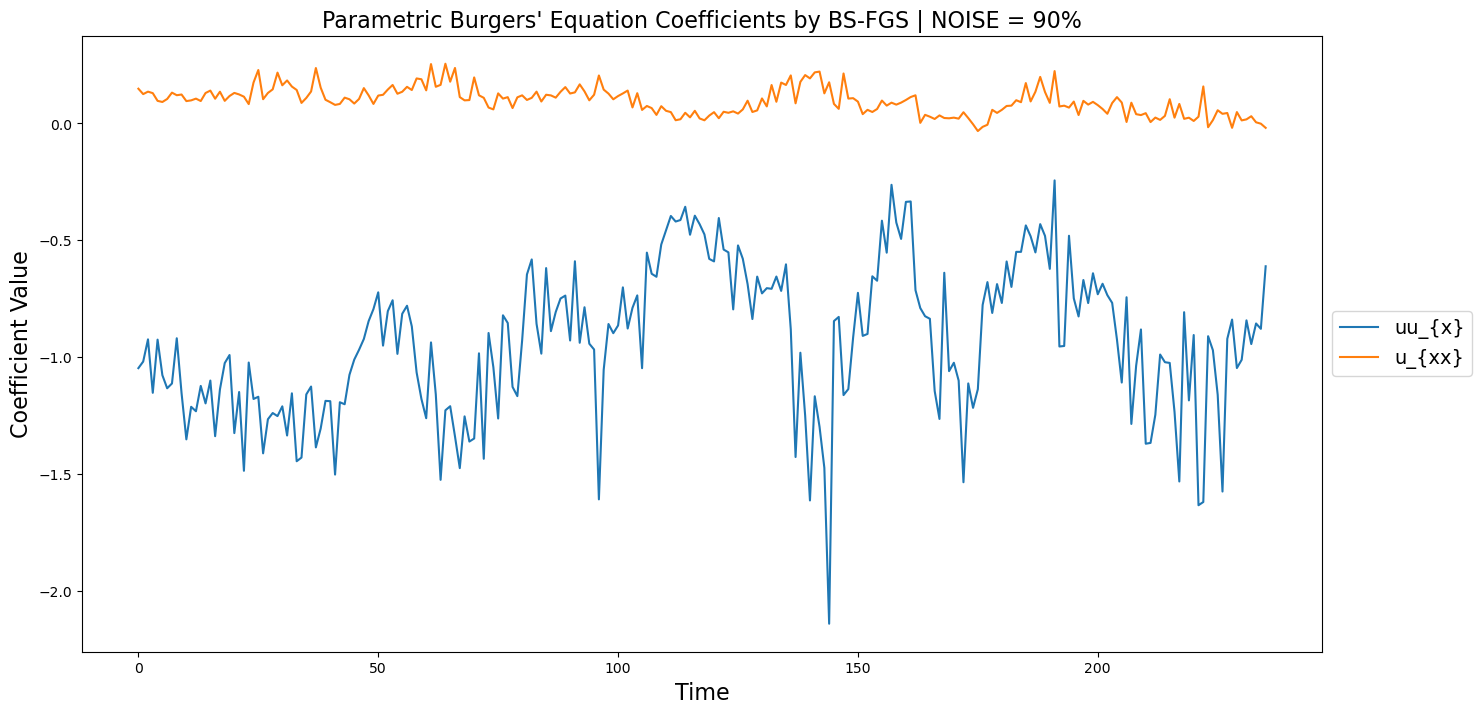

In [30]:
fig = plt.figure(figsize=(16, 8))
for j in range(xi.shape[0]): 
    if np.linalg.norm(xi[j,:]) > 10**-10:
        plt.plot(xi[j,:], label = rhs_des[best_indices[j]])

plt.title(f"Parametric Burgers' Equation Coefficients by BS-FGS | NOISE = {int(noise_lv)}%", fontsize = 16)
plt.xlabel('Time', fontsize = 16)
plt.ylabel('Coefficient Value', fontsize = 16)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)
# plt.savefig("./imgs/bs-fgs_coefficients_90%noise.pdf")
plt.show()

In [31]:
# noise_lv = 2: (13.47426429638832, 9.661471905427707) (native env)
# noise_lv = 6: (34.52568950556214, 23.75175590500719) (pysr env)
# noise_lv = 90: (62.94915384049288, 16.715559578461846) (pysr env)
if wx > 0 and wt > 0:
    errs = np.array([100*np.linalg.norm(xi[0, :]-ground, 1)/np.linalg.norm(ground, 1), 
                     100*(np.abs(xi[1, :].mean()-0.1))/0.1])
else:
    errs = np.array([100*np.linalg.norm(xi[0, :]-ground, 1)/np.linalg.norm(ground, 1), 
                     100*(np.abs(xi[1, :].mean()-0.1))/0.1])
# (13.92231302257601, 10.160209521593307)
errs.mean(), errs.std()

(13.92231302257601, 10.160209521593307)

In [32]:
# np.save("./tmp_data/xi.npy", xi)
# np.save("./tmp_data/t.npy", t)

#### Notes
    - ไม่มี noisy (x, t) แล้วจร้าาา...
    - max noise_lv = 6 -> failed all
    - max noise_lv = 5 -> ABESS passed
    - max noise_lv = 2 -> STGRidge failed

#### Plans
    *- penalty for high-order derivatives and high-degree polynomials
    *- noise lv -> 1, 2, 3, 4, 5, 6, ... report with relative l2 error
    *- เอา noise มากสุดที่ทนได้่ -> Plot BIC, AIC with complexity and its assoc effective terms + signals ของ ABESS  ที่รอด + signals จาก STGRidge ที่ failed
    *- Explain ABESS in short + proposed algo for ordinary PDEs, parametric PDEs
    *- Symbolic regression -> Finetune using parametic PINNs (แค่นี้น่าจะพอ) / denoising parametic PINNs
    - Finetune using PINNs (แค่นี้น่าจะพอ) / denoising PINNs
    - NN: Pretrain solver and coefficient learners | Combine the networks and learn from the denoised u and functional coefficients.